In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
wind_table = Table.read('wind_data.ecsv').to_pandas()
shake_table = Table.read('wind_shake.ecsv').to_pandas()
exposure_table = Table.read('exposure_data.ecsv').to_pandas()
desi_spectiles_table = Table.read('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/tiles-specstatus.ecsv').to_pandas()
desi_exposures_table = Table.read('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/exposures.ecsv').to_pandas()

In [16]:
wind_table[:2], len(wind_table)

(            MJD           TIMESTAMP  WIND_SPEED  WIND_DIRECTION       GUST
 0  58569.131042 2019-03-27 03:08:42   17.200001      168.000000  99.300003
 1  58569.132477 2019-03-27 03:10:46   14.300000      175.699997  99.300003,
 1036477)

In [17]:
shake_table[:2], len(shake_table)

(            MJD           TIMESTAMP  WIND_GUST  WIND_SHAKE
 0  59307.129074 2021-04-03 03:05:52          1           0
 1  59307.129213 2021-04-03 03:06:04          1           1,
 102178)

In [18]:
exposure_table[:2], len(exposure_table)

(   EXPID           MJD                  TIMESTAMP      EXPTIME SURVEY PROGRAM  \
 0  90224  59364.148239 2021-05-30 03:33:27.849600   348.878632    sv3  BACKUP   
 1  90225  59364.154715 2021-05-30 03:42:47.376000  1054.206299    sv3  BRIGHT   
 
     MOUNT_EL    MOUNT_AZ  
 0  81.250550  143.299106  
 1  56.109587  201.243202  ,
 20484)

In [20]:
desi_spectiles_table[:2], len(desi_spectiles_table)

(   TILEID SURVEY FAPRGRM FAFLAVOR  NEXP  EXPTIME   TILERA  TILEDEC  \
 0       1    sv3    dark  sv3dark     3   2299.4  150.040    2.286   
 1       2    sv3    dark  sv3dark     2   1900.4  150.061    2.069   
 
    EFFTIME_ETC  EFFTIME_SPEC  ...  BGS_EFFTIME_BRIGHT  LYA_EFFTIME_DARK  \
 0       1409.3        1646.8  ...              1738.7            1577.3   
 1       1411.1        1331.7  ...              1418.9            1369.3   
 
   GOALTYPE MINTFRAC  LASTNIGHT    QA  USER  OVERRIDE QANIGHT  ARCHIVEDATE  
 0     dark      0.9   20210406  none  none         0       0     20210407  
 1     dark      0.9   20210407  none  none         0       0     20210408  
 
 [2 rows x 26 columns],
 18833)

In [21]:
desi_exposures_table[:2], len(desi_exposures_table)

(      NIGHT  TILEID  EXPID  OBSTYPE               PROGRAM  EXPTIME  \
 0  20191219   59209  33843  SCIENCE  Spectgrograph Data f     60.0   
 1  20191219   59209  33845  SCIENCE  Spectrograph Data fo     60.0   
 
    EFFTIME_ETC  EFFTIME_SPEC  EFFTIME  GOALTIME QUALITY COMMENTS  
 0         -1.0          -1.0     60.0      -1.0    good      NaN  
 1         -1.0          -1.0     60.0      -1.0    good      NaN  ,
 33624)

In [22]:
set(exposure_table['PROGRAM'])

{'BACKUP', 'BRIGHT', 'DARK'}

In [23]:
def calculate_angle_difference(angle1, angle2):
    """
    Calculate the absolute angular difference between two angles in degrees,
    considering the circular nature of angles (0-360 degrees).
    
    Parameters:
    -----------
    angle1, angle2 : float
        Angles in degrees
        
    Returns:
    --------
    float
        Absolute angular difference in degrees (0-180)
    """
    diff = abs(angle1 - angle2) % 360
    return min(diff, 360 - diff)

def add_wind_statistics(exposure_table, shake_table, wind_table):
    """
    Add columns to exposure_table containing wind statistics from both shake_table 
    and wind_table within each exposure's time window, including the opening angle
    between wind direction and telescope pointing.
    
    Parameters:
    -----------
    exposure_table : pandas.DataFrame
        Table containing exposure information with columns:
        MJD, TIMESTAMP, PROGRAM, MOUNT_AZ
    shake_table : pandas.DataFrame
        Table containing wind shake information with columns:
        MJD, TIMESTAMP, WIND_GUST, WIND_SHAKE
    wind_table : pandas.DataFrame
        Table containing wind measurements with columns:
        MJD, TIMESTAMP, WIND_SPEED, WIND_DIRECTION, GUST
        
    Returns:
    --------
    pandas.DataFrame
        exposure_table with additional wind statistics columns
    """
    # Create a copy of the exposure table to avoid modifying the original
    result_table = exposure_table.copy()
    
    # Define window lengths in seconds for each program type
    window_lengths = {
        'BACKUP': 300,
        'BRIGHT': 600,
        'DARK': 1200
    }
    
    # Initialize new columns with zeros
    new_columns = [
        'WIND_GUST_SUM', 'WIND_SHAKE_SUM',  # From shake_table
        'WIND_SPEED_AVG', 'WIND_SPEED_STD',  # From wind_table
        'WIND_DIRECTION_AVG', 'WIND_DIRECTION_STD',
        'GUST_AVG', 'GUST_STD',
        'WIND_OPENING_ANGLE'  
    ]
    for col in new_columns:
        result_table[col] = 0.0
    
    # Convert timestamps to pandas datetime
    shake_times = pd.to_datetime(shake_table['TIMESTAMP'])
    wind_times = pd.to_datetime(wind_table['TIMESTAMP'])
    
    # Process each exposure
    for i in range(len(result_table)):
        if((i%1000)==0):
            print(i, len(result_table))
        # Get the current row
        row = result_table.iloc[i]
        
        # Get the end time of the exposure
        start_time = pd.to_datetime(row['TIMESTAMP'])
        
        # Calculate start time based on the program type
        window_length = row['EXPTIME']
        end_time = start_time + pd.Timedelta(seconds=window_length)
        
        # Find all shake_table entries within this time window
        shake_mask = (shake_times >= start_time) & (shake_times <= end_time)
        shake_window = shake_table[shake_mask]
        
        # Calculate statistics from shake_table
        result_table.iloc[i, result_table.columns.get_loc('WIND_GUST_SUM')] = shake_window['WIND_GUST'].sum()
        result_table.iloc[i, result_table.columns.get_loc('WIND_SHAKE_SUM')] = shake_window['WIND_SHAKE'].sum()
        
        # Find all wind_table entries within this time window
        wind_mask = (wind_times >= start_time) & (wind_times <= end_time)
        wind_window = wind_table[wind_mask]
        
        # Calculate statistics from wind_table
        if len(wind_window) > 0:  # Only calculate if we have data points
            # Wind speed statistics
            result_table.iloc[i, result_table.columns.get_loc('WIND_SPEED_AVG')] = wind_window['WIND_SPEED'].mean()
            result_table.iloc[i, result_table.columns.get_loc('WIND_SPEED_STD')] = wind_window['WIND_SPEED'].std()
            
            # Wind direction statistics
            result_table.iloc[i, result_table.columns.get_loc('WIND_DIRECTION_AVG')] = wind_window['WIND_DIRECTION'].mean()
            result_table.iloc[i, result_table.columns.get_loc('WIND_DIRECTION_STD')] = wind_window['WIND_DIRECTION'].std()
            
            # Gust statistics
            result_table.iloc[i, result_table.columns.get_loc('GUST_AVG')] = wind_window['GUST'].mean()
            result_table.iloc[i, result_table.columns.get_loc('GUST_STD')] = wind_window['GUST'].std()
            
            # Calculate opening angle between wind direction and telescope pointing
            wind_direction_avg = wind_window['WIND_DIRECTION'].mean()
            telescope_az = row['MOUNT_AZ']
            opening_angle = calculate_angle_difference(wind_direction_avg, telescope_az)
            result_table.iloc[i, result_table.columns.get_loc('WIND_OPENING_ANGLE')] = opening_angle
    
    return result_table

In [24]:
def add_tile_information(exposure_table, desi_exposures_table, desi_spectiles_table):
    """
    Add TILEID, TILERA, and TILEDEC information from desi_spectiles_table to exposure_table,
    using desi_exposures_table as a bridge.
    
    Parameters:
    -----------
    exposure_table : pandas.DataFrame
        Table containing exposure information
    desi_exposures_table : pandas.DataFrame
        DESI exposures table that contains EXPID and TILEID
    desi_spectiles_table : pandas.DataFrame
        DESI spectiles table that contains TILEID, TILERA, and TILEDEC
        
    Returns:
    --------
    pandas.DataFrame
        exposure_table with additional tile information columns
    """
    # Create a copy of the exposure table to avoid modifying the original
    result_table = exposure_table.copy()
    
    # Initialize new columns with NaN values
    result_table['TILEID'] = float('nan')
    result_table['TILERA'] = float('nan')
    result_table['TILEDEC'] = float('nan')
    
    # Create a mapping from EXPID to TILEID using desi_exposures_table
    expid_to_tileid = dict(zip(desi_exposures_table['EXPID'], desi_exposures_table['TILEID']))
    
    # Create a mapping from TILEID to (TILERA, TILEDEC) using desi_spectiles_table
    tileid_to_coords = {}
    for _, row in desi_spectiles_table.iterrows():
        tileid_to_coords[row['TILEID']] = (row['TILERA'], row['TILEDEC'])
    
    # Process each exposure
    for i in range(len(result_table)):
        if((i%1000)==0):
            print(i, len(result_table))
        
        # Get the current EXPID
        expid = result_table.iloc[i]['EXPID']
        
        # Look up the TILEID for this EXPID
        if expid in expid_to_tileid:
            tileid = expid_to_tileid[expid]
            result_table.iloc[i, result_table.columns.get_loc('TILEID')] = tileid
            
            # Look up the TILERA and TILEDEC for this TILEID
            if tileid in tileid_to_coords:
                tilera, tiledec = tileid_to_coords[tileid]
                result_table.iloc[i, result_table.columns.get_loc('TILERA')] = tilera
                result_table.iloc[i, result_table.columns.get_loc('TILEDEC')] = tiledec
    
    return result_table

In [25]:
new_exposure_table = add_wind_statistics(exposure_table, shake_table, wind_table)

0 20484
1000 20484
2000 20484
3000 20484
4000 20484
5000 20484
6000 20484
7000 20484
8000 20484
9000 20484
10000 20484
11000 20484
12000 20484
13000 20484
14000 20484
15000 20484
16000 20484
17000 20484
18000 20484
19000 20484
20000 20484


In [26]:
new_exposure_table = add_tile_information(new_exposure_table, desi_exposures_table, desi_spectiles_table)

0 20484
1000 20484
2000 20484
3000 20484
4000 20484
5000 20484
6000 20484
7000 20484
8000 20484
9000 20484
10000 20484
11000 20484
12000 20484
13000 20484
14000 20484
15000 20484
16000 20484
17000 20484
18000 20484
19000 20484
20000 20484


In [27]:
new_exposure_astropy = Table.from_pandas(new_exposure_table)
new_exposure_astropy.write('extended_exposure_data.ecsv', format='ascii.ecsv', overwrite=True)

In [28]:
new_exposure_table = Table.read('extended_exposure_data.ecsv').to_pandas()

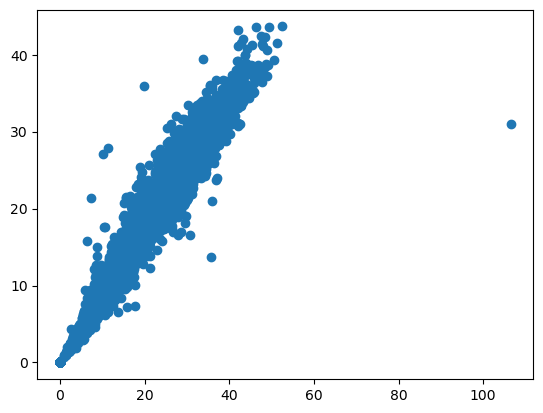

In [29]:
plt.scatter(new_exposure_table['WIND_SPEED_AVG'],new_exposure_table['GUST_AVG'])

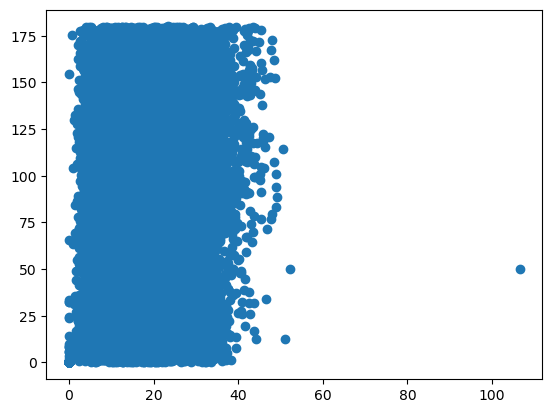

In [30]:
plt.scatter(new_exposure_table['WIND_SPEED_AVG'],new_exposure_table['WIND_OPENING_ANGLE'])

(array([1.91e+04, 5.03e+02, 1.98e+02, 1.03e+02, 9.60e+01, 7.50e+01,
        6.40e+01, 4.20e+01, 7.00e+00, 1.00e+00]),
 array([  0.        ,  20.05354767,  40.10709534,  60.16064301,
         80.21419067, 100.26773834, 120.32128601, 140.37483368,
        160.42838135, 180.48192902, 200.53547668]),
 <BarContainer object of 10 artists>)

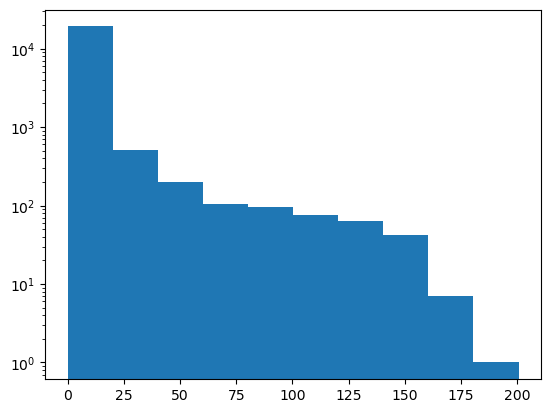

In [55]:
ii = new_exposure_table['WIND_OPENING_ANGLE']>1E-3
plt.hist(new_exposure_table['WIND_DIRECTION_STD'], log=True)

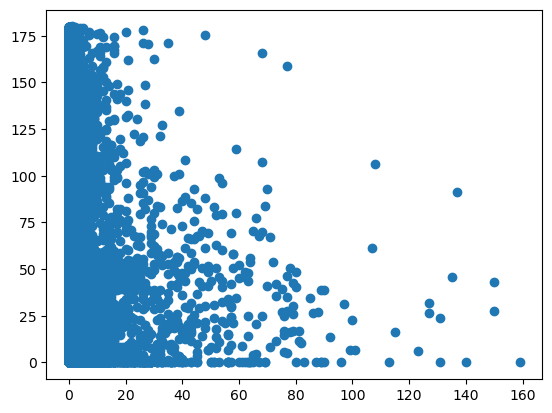

In [31]:
plt.scatter(new_exposure_table['WIND_SHAKE_SUM'],new_exposure_table['WIND_OPENING_ANGLE'])

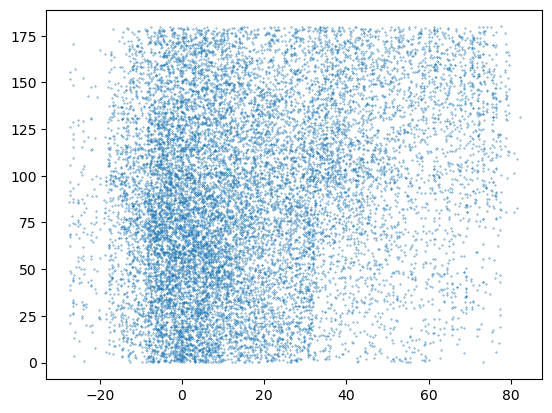

In [36]:
ii = new_exposure_table['WIND_OPENING_ANGLE']>1E-3
plt.scatter(new_exposure_table['TILEDEC'][ii], new_exposure_table['WIND_OPENING_ANGLE'][ii] , s=0.1)

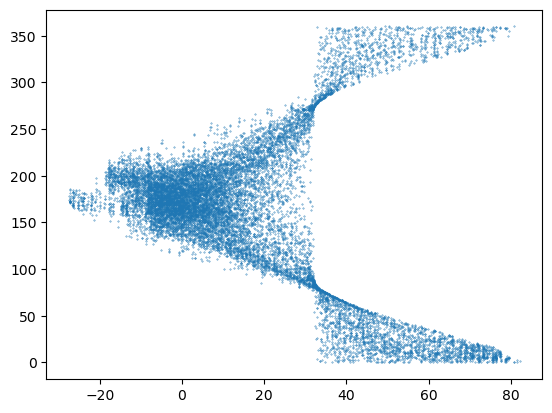

In [56]:
plt.scatter(new_exposure_table['TILEDEC'][ii], new_exposure_table['MOUNT_AZ'][ii] , s=0.1)

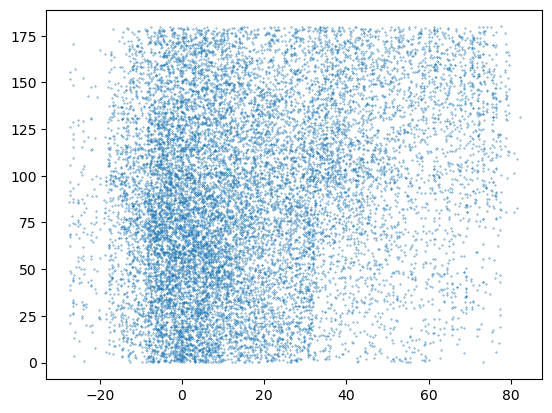

In [44]:
ii = new_exposure_table['WIND_OPENING_ANGLE']>1E-3
plt.scatter(new_exposure_table['TILEDEC'][ii], new_exposure_table['WIND_OPENING_ANGLE'][ii] , s=0.1)

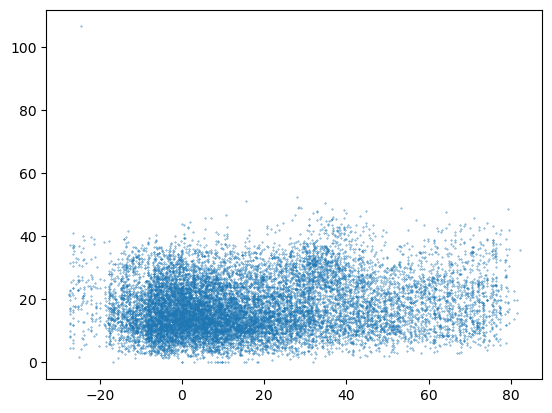

In [45]:
ii = new_exposure_table['WIND_OPENING_ANGLE']>1E-3
plt.scatter(new_exposure_table['TILEDEC'][ii], new_exposure_table['WIND_SPEED_AVG'][ii] , s=0.1)

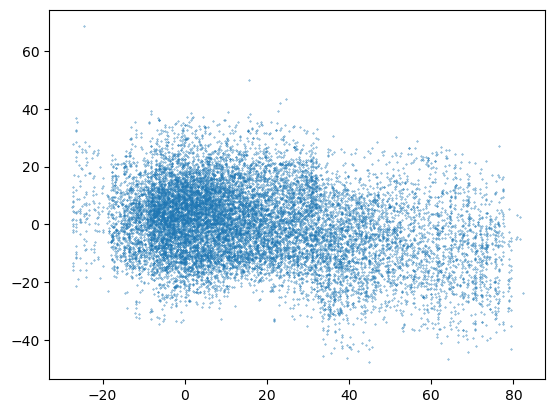

In [50]:
ii = new_exposure_table['WIND_OPENING_ANGLE']>1E-3
plt.scatter(new_exposure_table['TILEDEC'][ii], 
            new_exposure_table['WIND_SPEED_AVG'][ii]*np.cos(np.deg2rad(new_exposure_table['WIND_OPENING_ANGLE'][ii])) , s=0.1)

Saved histogram figure to ./wind_impact_histograms_dec30.pdf
Saved scatter plot figure to ./declination_vs_wind_impact_dec30.pdf
Saved comparison figure to ./wind_impact_comparison_dec30.pdf


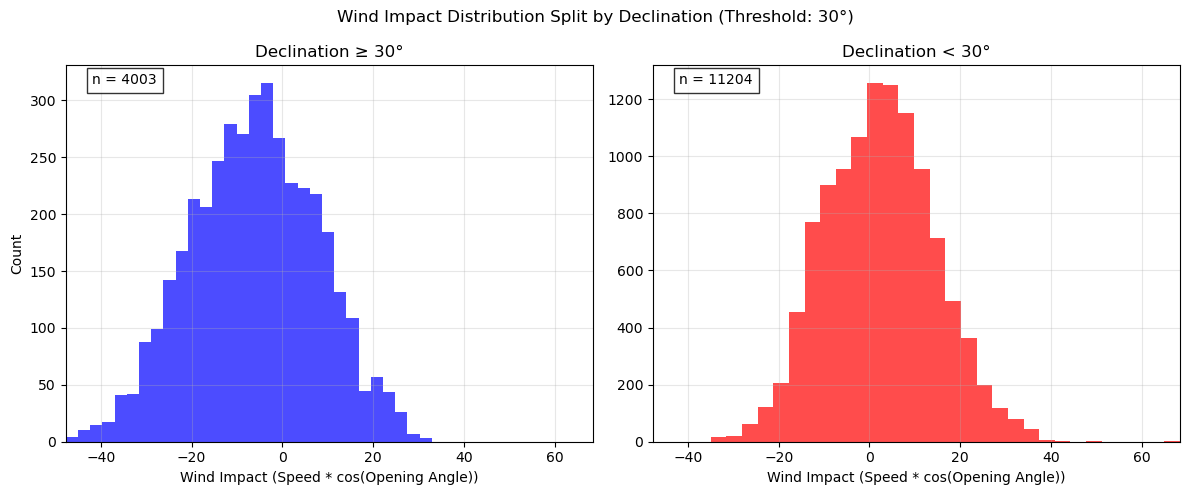

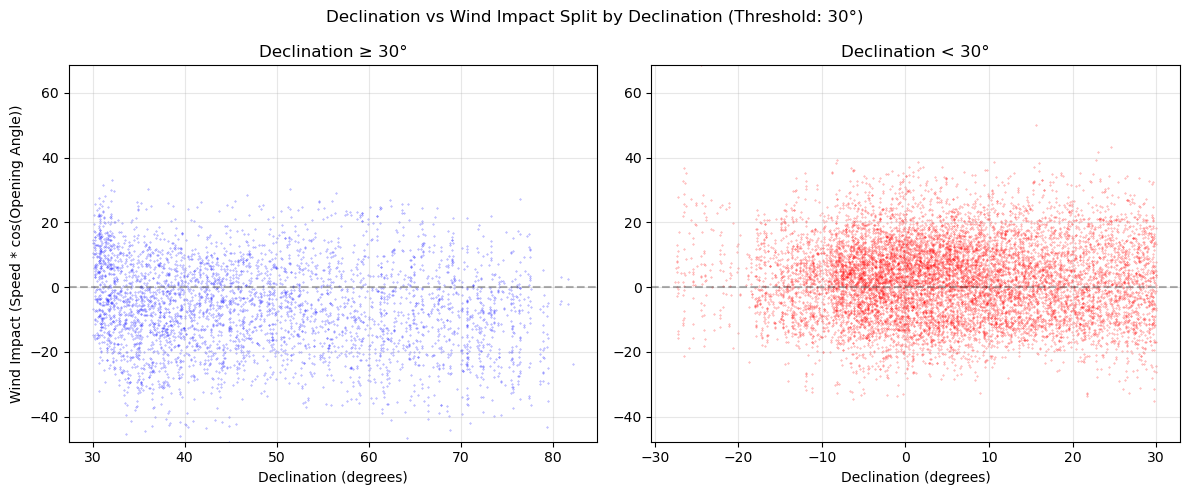

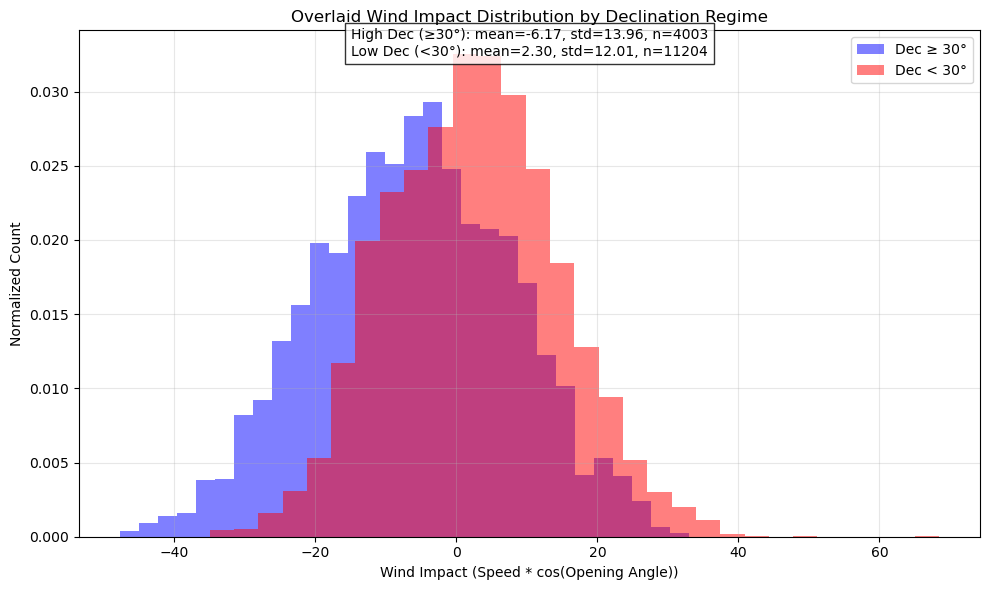

In [62]:
def plot_wind_impact_by_declination(exposure_table, declination_threshold=30, save_path='./'):
    """
    Plot the distribution of wind impact (WIND_SPEED_AVG * cos(WIND_OPENING_ANGLE))
    for two different declination regimes: above and below the specified threshold.
    
    Parameters:
    -----------
    exposure_table : pandas.DataFrame
        Table containing exposure information with columns:
        TILEDEC, WIND_SPEED_AVG, WIND_OPENING_ANGLE
    declination_threshold : float, optional
        The declination threshold in degrees, default is 30
    save_path : str, optional
        Directory path where to save the PDF figures, default is current directory
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    
    # Create a mask for rows with valid wind opening angles
    wind_mask = exposure_table['WIND_OPENING_ANGLE'] > 1E-3
    
    # Calculate the y-axis value (wind impact) for all valid rows
    wind_impact = exposure_table['WIND_SPEED_AVG'][wind_mask] * np.cos(np.deg2rad(exposure_table['WIND_OPENING_ANGLE'][wind_mask]))
    
    # Create masks for the two declination regimes
    high_dec_mask = exposure_table['TILEDEC'][wind_mask] >= declination_threshold
    low_dec_mask = exposure_table['TILEDEC'][wind_mask] < declination_threshold
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Wind Impact Distribution Split by Declination (Threshold: {declination_threshold}°)')
    
    # Plot for high declination
    ax1.hist(wind_impact[high_dec_mask], bins=30, alpha=0.7, color='blue')
    ax1.set_title(f'Declination ≥ {declination_threshold}°')
    ax1.set_xlabel('Wind Impact (Speed * cos(Opening Angle))')
    ax1.set_ylabel('Count')
    ax1.grid(alpha=0.3)
    ax1.text(0.05, 0.95, f'n = {sum(high_dec_mask)}', 
             transform=ax1.transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Plot for low declination
    ax2.hist(wind_impact[low_dec_mask], bins=30, alpha=0.7, color='red')
    ax2.set_title(f'Declination < {declination_threshold}°')
    ax2.set_xlabel('Wind Impact (Speed * cos(Opening Angle))')
    ax2.grid(alpha=0.3)
    ax2.text(0.05, 0.95, f'n = {sum(low_dec_mask)}', 
             transform=ax2.transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Ensure both histograms have the same x and y limits for easier comparison
    x_min = min(wind_impact.min(), wind_impact.min())
    x_max = max(wind_impact.max(), wind_impact.max())
    ax1.set_xlim(x_min, x_max)
    ax2.set_xlim(x_min, x_max)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the first figure as PDF
    fig1_path = os.path.join(save_path, f'wind_impact_histograms_dec{declination_threshold}.pdf')
    fig.savefig(fig1_path, format='pdf', bbox_inches='tight')
    print(f"Saved histogram figure to {fig1_path}")
    
    # Create a figure for scatter plots
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
    fig2.suptitle(f'Declination vs Wind Impact Split by Declination (Threshold: {declination_threshold}°)')
    
    # Scatter plot for high declination
    scatter1 = ax3.scatter(
        exposure_table['TILEDEC'][wind_mask][high_dec_mask],
        wind_impact[high_dec_mask],
        alpha=0.5, c='blue', s=0.1
    )
    ax3.set_title(f'Declination ≥ {declination_threshold}°')
    ax3.set_xlabel('Declination (degrees)')
    ax3.set_ylabel('Wind Impact (Speed * cos(Opening Angle))')
    ax3.grid(alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # Scatter plot for low declination
    scatter2 = ax4.scatter(
        exposure_table['TILEDEC'][wind_mask][low_dec_mask],
        wind_impact[low_dec_mask],
        alpha=0.5, c='red', s=0.1
    )
    ax4.set_title(f'Declination < {declination_threshold}°')
    ax4.set_xlabel('Declination (degrees)')
    ax4.grid(alpha=0.3)
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # Set the same y-limits for both scatter plots
    y_min = min(wind_impact.min(), wind_impact.min())
    y_max = max(wind_impact.max(), wind_impact.max())
    ax3.set_ylim(y_min, y_max)
    ax4.set_ylim(y_min, y_max)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the second figure as PDF
    fig2_path = os.path.join(save_path, f'declination_vs_wind_impact_dec{declination_threshold}.pdf')
    fig2.savefig(fig2_path, format='pdf', bbox_inches='tight')
    print(f"Saved scatter plot figure to {fig2_path}")
    
    # Additional combined histogram for comparison
    fig3, ax5 = plt.subplots(figsize=(10, 6))
    ax5.hist(wind_impact[high_dec_mask], bins=30, alpha=0.5, color='blue', label=f'Dec ≥ {declination_threshold}°', density=True)
    ax5.hist(wind_impact[low_dec_mask], bins=30, alpha=0.5, color='red', label=f'Dec < {declination_threshold}°', density=True)
    ax5.set_title('Overlaid Wind Impact Distribution by Declination Regime')
    ax5.set_xlabel('Wind Impact (Speed * cos(Opening Angle))')
    ax5.set_ylabel('Normalized Count')
    ax5.legend()
    ax5.grid(alpha=0.3)
    
    # Calculate and display basic statistics
    high_dec_mean = wind_impact[high_dec_mask].mean()
    low_dec_mean = wind_impact[low_dec_mask].mean()
    high_dec_std = wind_impact[high_dec_mask].std()
    low_dec_std = wind_impact[low_dec_mask].std()
    
    stats_text = (
        f"High Dec (≥{declination_threshold}°): mean={high_dec_mean:.2f}, std={high_dec_std:.2f}, n={sum(high_dec_mask)}\n"
        f"Low Dec (<{declination_threshold}°): mean={low_dec_mean:.2f}, std={low_dec_std:.2f}, n={sum(low_dec_mask)}"
    )
    ax5.text(0.5, 0.95, stats_text, 
             transform=ax5.transAxes, ha='center',
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save the third figure as PDF
    fig3_path = os.path.join(save_path, f'wind_impact_comparison_dec{declination_threshold}.pdf')
    fig3.savefig(fig3_path, format='pdf', bbox_inches='tight')
    print(f"Saved comparison figure to {fig3_path}")
    
    return fig, fig2, fig3

# Usage example:
fig1, fig2, fig3 = plot_wind_impact_by_declination(new_exposure_table, declination_threshold=30, save_path='./')

Saved DARK program figure to ./wind_impact_DARK_dec30.pdf
Saved BRIGHT program figure to ./wind_impact_BRIGHT_dec30.pdf
Saved BACKUP program figure to ./wind_impact_BACKUP_dec30.pdf
Saved combined programs figure to ./wind_impact_all_programs_dec30.pdf


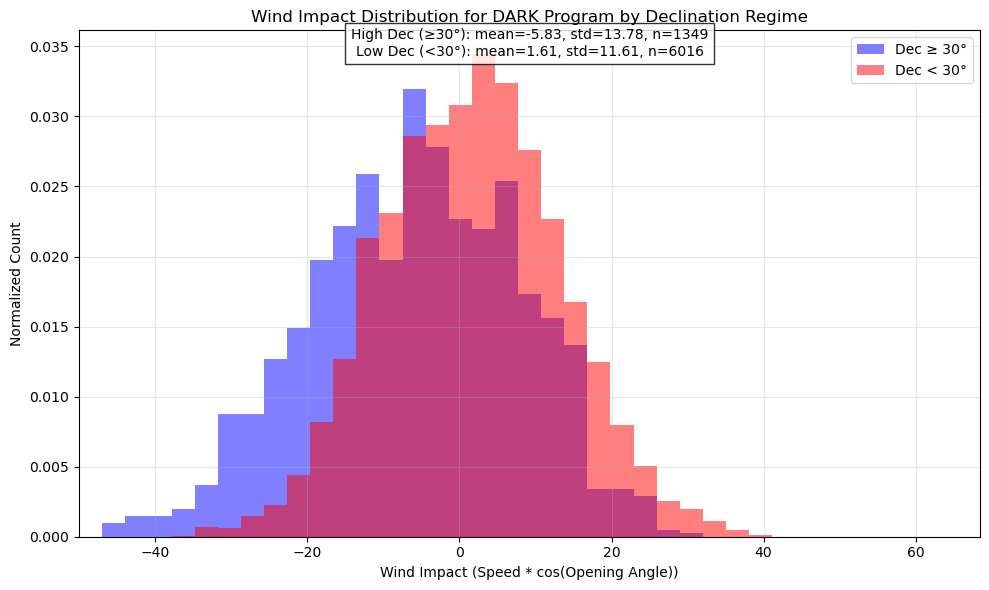

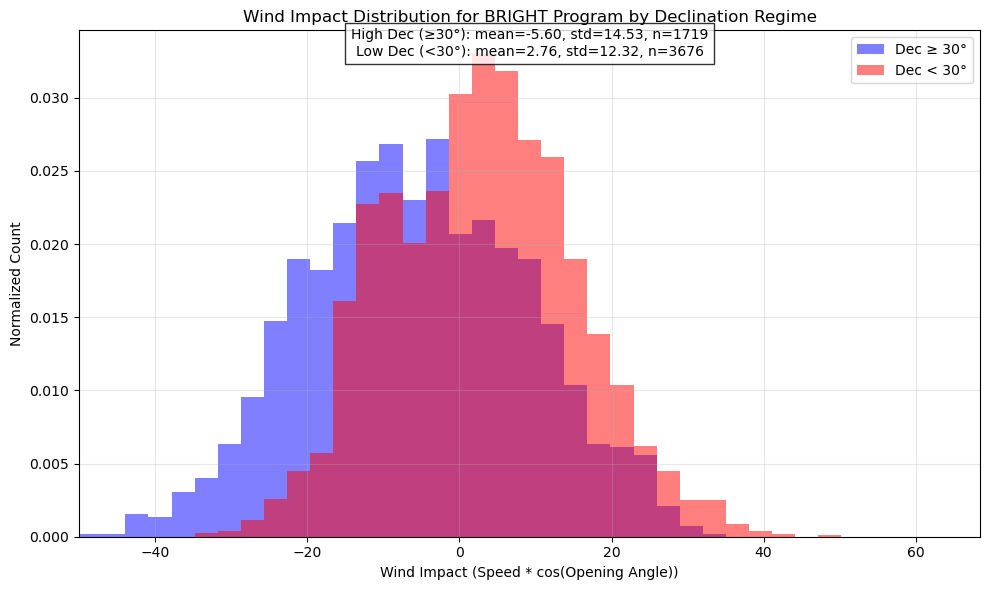

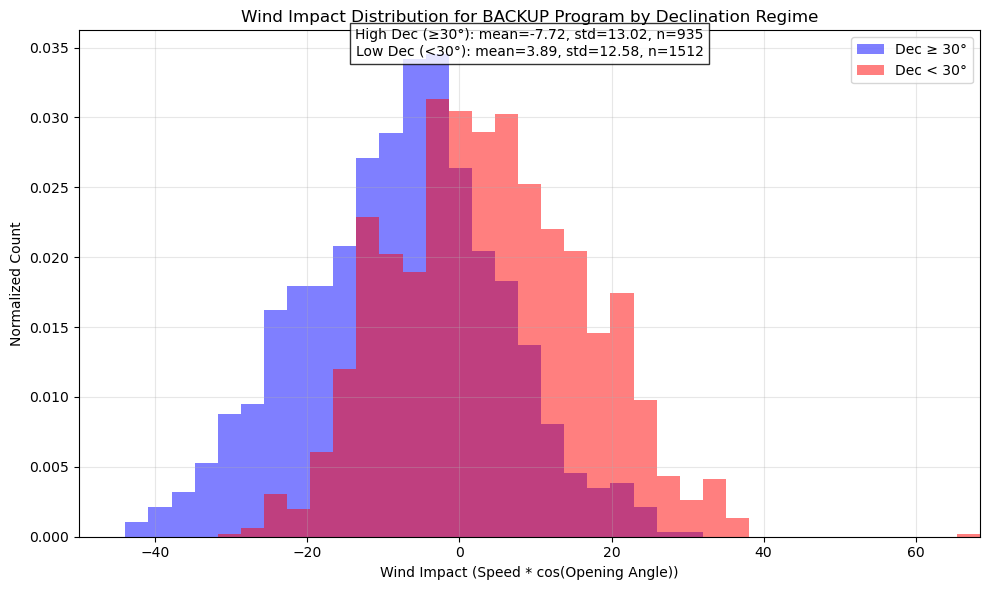

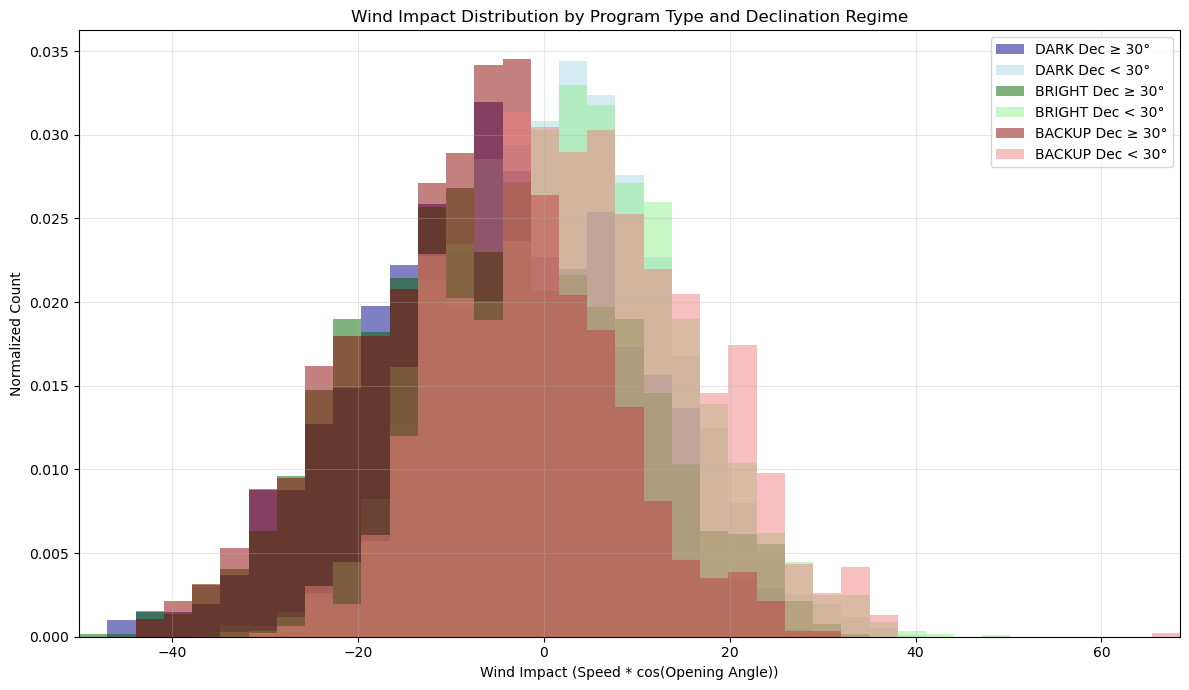

In [64]:
def plot_wind_impact_by_program(exposure_table, declination_threshold=30, save_path='./'):
    """
    Creates three separate plots showing wind impact distribution for each program type (DARK, BRIGHT, BACKUP),
    with each plot showing the split between high and low declination observations.
    
    Parameters:
    -----------
    exposure_table : pandas.DataFrame
        Table containing exposure information with columns:
        TILEDEC, WIND_SPEED_AVG, WIND_OPENING_ANGLE, PROGRAM
    declination_threshold : float, optional
        The declination threshold in degrees, default is 30
    save_path : str, optional
        Directory path where to save the PDF figures, default is current directory
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    
    # Create a mask for rows with valid wind opening angles
    wind_mask = exposure_table['WIND_OPENING_ANGLE'] > 1E-3
    
    # Calculate the y-axis value (wind impact) for all valid rows
    wind_impact = exposure_table['WIND_SPEED_AVG'][wind_mask] * np.cos(np.deg2rad(exposure_table['WIND_OPENING_ANGLE'][wind_mask]))
    
    # Add wind impact as a column for easy filtering
    filtered_data = exposure_table[wind_mask].copy()
    filtered_data['WIND_IMPACT'] = wind_impact
    
    # Create masks for the two declination regimes
    high_dec_mask = filtered_data['TILEDEC'] >= declination_threshold
    low_dec_mask = filtered_data['TILEDEC'] < declination_threshold
    
    # Define program types to analyze
    program_types = ['DARK', 'BRIGHT', 'BACKUP']
    
    # Create separate figures for each program type
    for program in program_types:
        # Filter data for this program
        program_mask = filtered_data['PROGRAM'] == program
        program_data = filtered_data[program_mask]
        
        # Get high and low declination data for this program
        program_high_dec = program_data[high_dec_mask[program_mask]]
        program_low_dec = program_data[low_dec_mask[program_mask]]
        
        # Calculate statistics for this program
        high_dec_mean = program_high_dec['WIND_IMPACT'].mean() if not program_high_dec.empty else float('nan')
        high_dec_std = program_high_dec['WIND_IMPACT'].std() if not program_high_dec.empty else float('nan')
        high_dec_count = len(program_high_dec)
        
        low_dec_mean = program_low_dec['WIND_IMPACT'].mean() if not program_low_dec.empty else float('nan')
        low_dec_std = program_low_dec['WIND_IMPACT'].std() if not program_low_dec.empty else float('nan')
        low_dec_count = len(program_low_dec)
        
        # Create the figure
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Define bin range to keep consistent across all plots
        min_val = min(filtered_data['WIND_IMPACT'].min(), -50)  # Set a reasonable minimum
        max_val = max(filtered_data['WIND_IMPACT'].max(), 50)   # Set a reasonable maximum
        bins = np.linspace(min_val, max_val, 40)
        
        # Plot histograms if data exists
        if high_dec_count > 0:
            ax.hist(program_high_dec['WIND_IMPACT'], bins=bins, alpha=0.5, 
                    color='blue', label=f'Dec ≥ {declination_threshold}°', density=True)
        
        if low_dec_count > 0:
            ax.hist(program_low_dec['WIND_IMPACT'], bins=bins, alpha=0.5, 
                    color='red', label=f'Dec < {declination_threshold}°', density=True)
        
        # Set title and labels
        ax.set_title(f'Wind Impact Distribution for {program} Program by Declination Regime')
        ax.set_xlabel('Wind Impact (Speed * cos(Opening Angle))')
        ax.set_ylabel('Normalized Count')
        
        # Add legend if both histograms are plotted
        if high_dec_count > 0 or low_dec_count > 0:
            ax.legend()
        
        # Add grid
        ax.grid(alpha=0.3)
        
        # Format statistics text
        stats_text = ""
        if high_dec_count > 0:
            stats_text += f"High Dec (≥{declination_threshold}°): mean={high_dec_mean:.2f}, std={high_dec_std:.2f}, n={high_dec_count}\n"
        if low_dec_count > 0:
            stats_text += f"Low Dec (<{declination_threshold}°): mean={low_dec_mean:.2f}, std={low_dec_std:.2f}, n={low_dec_count}"
        
        # Add statistics text box
        ax.text(0.5, 0.95, stats_text, 
                transform=ax.transAxes, ha='center',
                bbox=dict(facecolor='white', alpha=0.8))
        
        # Define x-axis limits to be consistent across all plots
        ax.set_xlim(min_val, max_val)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save the figure as PDF
        fig_path = os.path.join(save_path, f'wind_impact_{program}_dec{declination_threshold}.pdf')
        fig.savefig(fig_path, format='pdf', bbox_inches='tight')
        print(f"Saved {program} program figure to {fig_path}")
    
    # Now create a single plot with all programs combined but still split by declination
    fig_combined, ax_combined = plt.subplots(figsize=(12, 7))
    
    # Colors for different programs
    program_colors = {
        'DARK': ['darkblue', 'lightblue'],
        'BRIGHT': ['darkgreen', 'lightgreen'],
        'BACKUP': ['darkred', 'lightcoral']
    }
    
    # Plot histograms for each program and declination combination
    for i, program in enumerate(program_types):
        program_mask = filtered_data['PROGRAM'] == program
        program_data = filtered_data[program_mask]
        
        # High declination
        high_data = program_data[high_dec_mask[program_mask]]
        if len(high_data) > 0:
            ax_combined.hist(high_data['WIND_IMPACT'], bins=bins, alpha=0.5,
                           color=program_colors[program][0], 
                           label=f'{program} Dec ≥ {declination_threshold}°', 
                           density=True)
        
        # Low declination
        low_data = program_data[low_dec_mask[program_mask]]
        if len(low_data) > 0:
            ax_combined.hist(low_data['WIND_IMPACT'], bins=bins, alpha=0.5,
                           color=program_colors[program][1], 
                           label=f'{program} Dec < {declination_threshold}°', 
                           density=True)
    
    # Set title and labels for combined plot
    ax_combined.set_title('Wind Impact Distribution by Program Type and Declination Regime')
    ax_combined.set_xlabel('Wind Impact (Speed * cos(Opening Angle))')
    ax_combined.set_ylabel('Normalized Count')
    ax_combined.legend()
    ax_combined.grid(alpha=0.3)
    
    # Set limits
    ax_combined.set_xlim(min_val, max_val)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the combined figure
    combined_fig_path = os.path.join(save_path, f'wind_impact_all_programs_dec{declination_threshold}.pdf')
    fig_combined.savefig(combined_fig_path, format='pdf', bbox_inches='tight')
    print(f"Saved combined programs figure to {combined_fig_path}")
    
    return

# Usage example:
plot_wind_impact_by_program(new_exposure_table, declination_threshold=30, save_path='./')

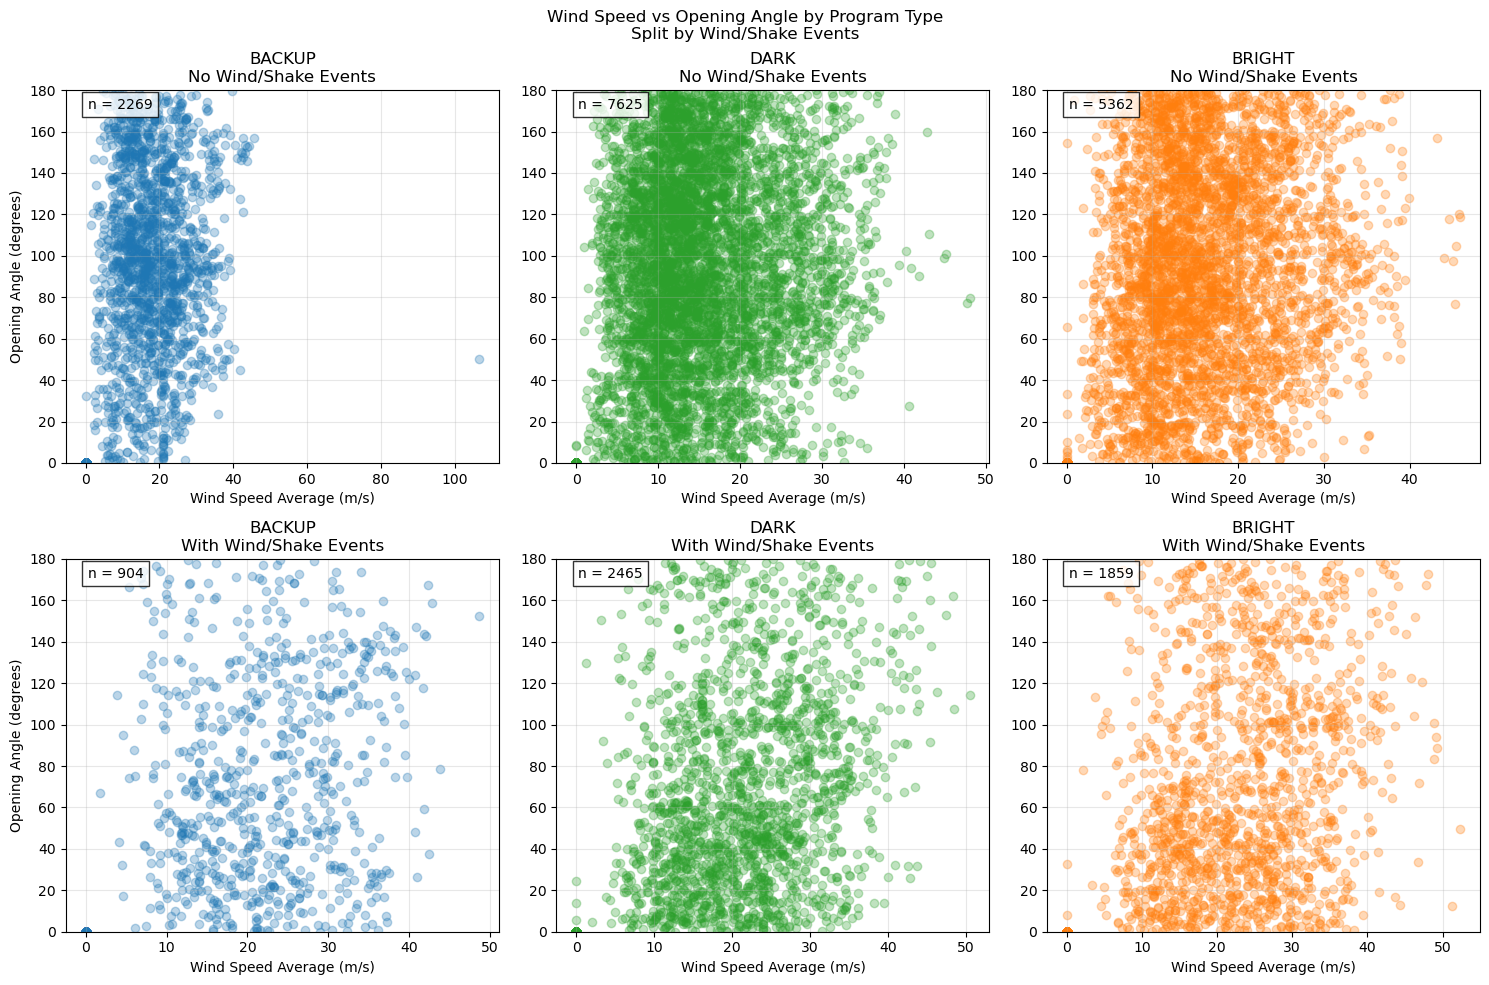

In [59]:
def plot_wind_speed_vs_angle_split(df):
    """
    Create a six-panel scatter plot of wind speed vs opening angle,
    separated by program type and presence/absence of wind/shake events.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM, WIND_SHAKE_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Wind Speed vs Opening Angle by Program Type\nSplit by Wind/Shake Events')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    
    # Create scatter plot for each program and condition
    for col, (program, color) in enumerate(zip(programs, colors)):
        for row, has_events in enumerate([False, True]):
            ax = axes[row, col]
            
            # Create mask for program and wind/shake condition
            program_mask = df['PROGRAM'] == program
            if has_events:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) > 0
                title_prefix = 'With'
            else:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) == 0
                title_prefix = 'No'
            
            combined_mask = program_mask & event_mask
            program_data = df[combined_mask]
            
            # Create scatter plot
            ax.scatter(program_data['WIND_SPEED_AVG'], 
                      program_data['WIND_OPENING_ANGLE'],
                      alpha=0.3, c=color, label=program)
            
            # Add labels
            ax.set_xlabel('Wind Speed Average (m/s)')
            if col == 0:
                ax.set_ylabel('Opening Angle (degrees)')
            ax.set_title(f'{program}\n{title_prefix} Wind/Shake Events')
            
            # Set y-axis limits
            ax.set_ylim(0, 180)
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add count of points
            count = len(program_data)
            ax.text(0.05, 0.95, f'n = {count}', 
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig('summary.pdf')
    return fig, axes

# Create the plot
fig, axes = plot_wind_speed_vs_angle_split(new_exposure_table)

# Display the plot
#plt.show()

In [35]:
def plot_cumulative_distributions(df):
    """
    Create three-panel plot showing cumulative distributions of wind speed,
    opening angle, and wind gust sum for each program type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Cumulative Distributions by Program Type')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    
    # Variables to plot with their labels
    variables = ['WIND_SPEED_AVG', 'WIND_OPENING_ANGLE', 'WIND_SHAKE_SUM']
    xlabels = ['Wind Speed (m/s)', 'Opening Angle (degrees)', 'Wind Shake Sum']
    
    # Create plots for each variable
    for ax, var, xlabel in zip(axes, variables, xlabels):
        for program, color in zip(programs, colors):
            # Get data for this program
            mask = df['PROGRAM'] == program
            data = df[mask][var].dropna()
            
            # Sort data and calculate cumulative distribution
            sorted_data = np.sort(data)
            cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            
            # Plot
            ax.plot(sorted_data, cumulative, 
                   label=f'{program} (n={len(data)})',
                   color=color, linewidth=2)
        
        # Customize each subplot
        ax.grid(True, alpha=0.3)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Cumulative Fraction' if ax == axes[0] else '')
        ax.legend()
        
        # Set y-axis limits
        ax.set_ylim(0, 1.05)
        
    # Adjust layout
    plt.tight_layout()
    
    return fig, axes

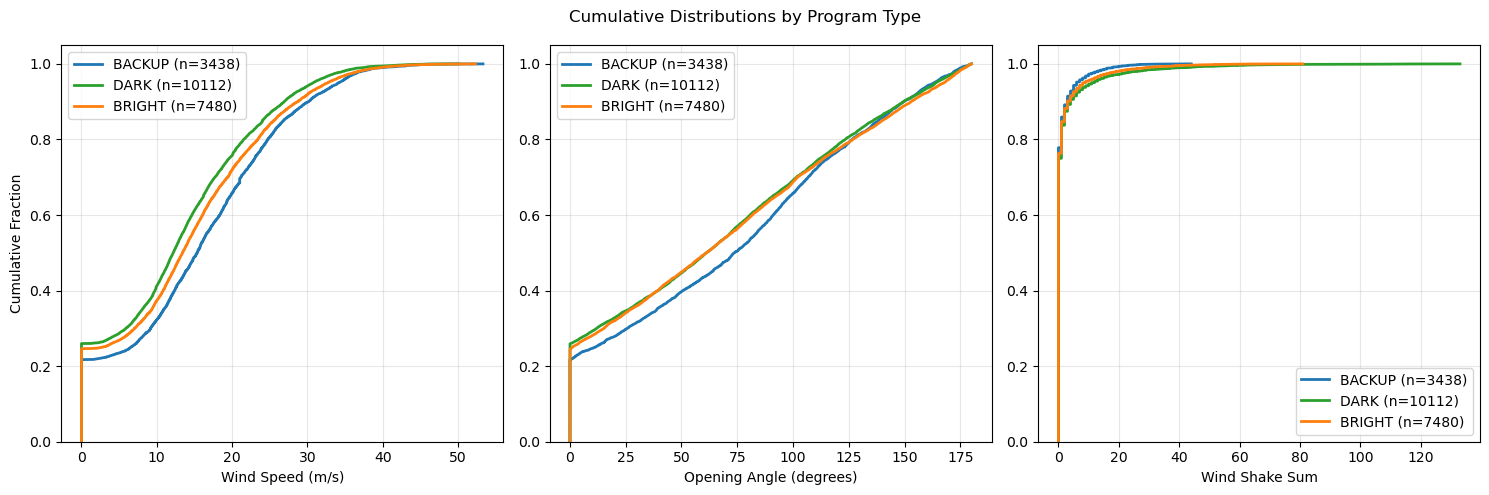

In [36]:
# Create the plot
fig, axes = plot_cumulative_distributions(new_exposure_table)

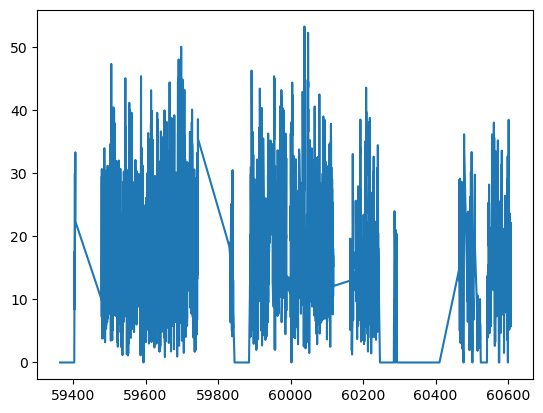

In [34]:
plt.plot(new_exposure_table['MJD'], new_exposure_table['WIND_SPEED_AVG'])

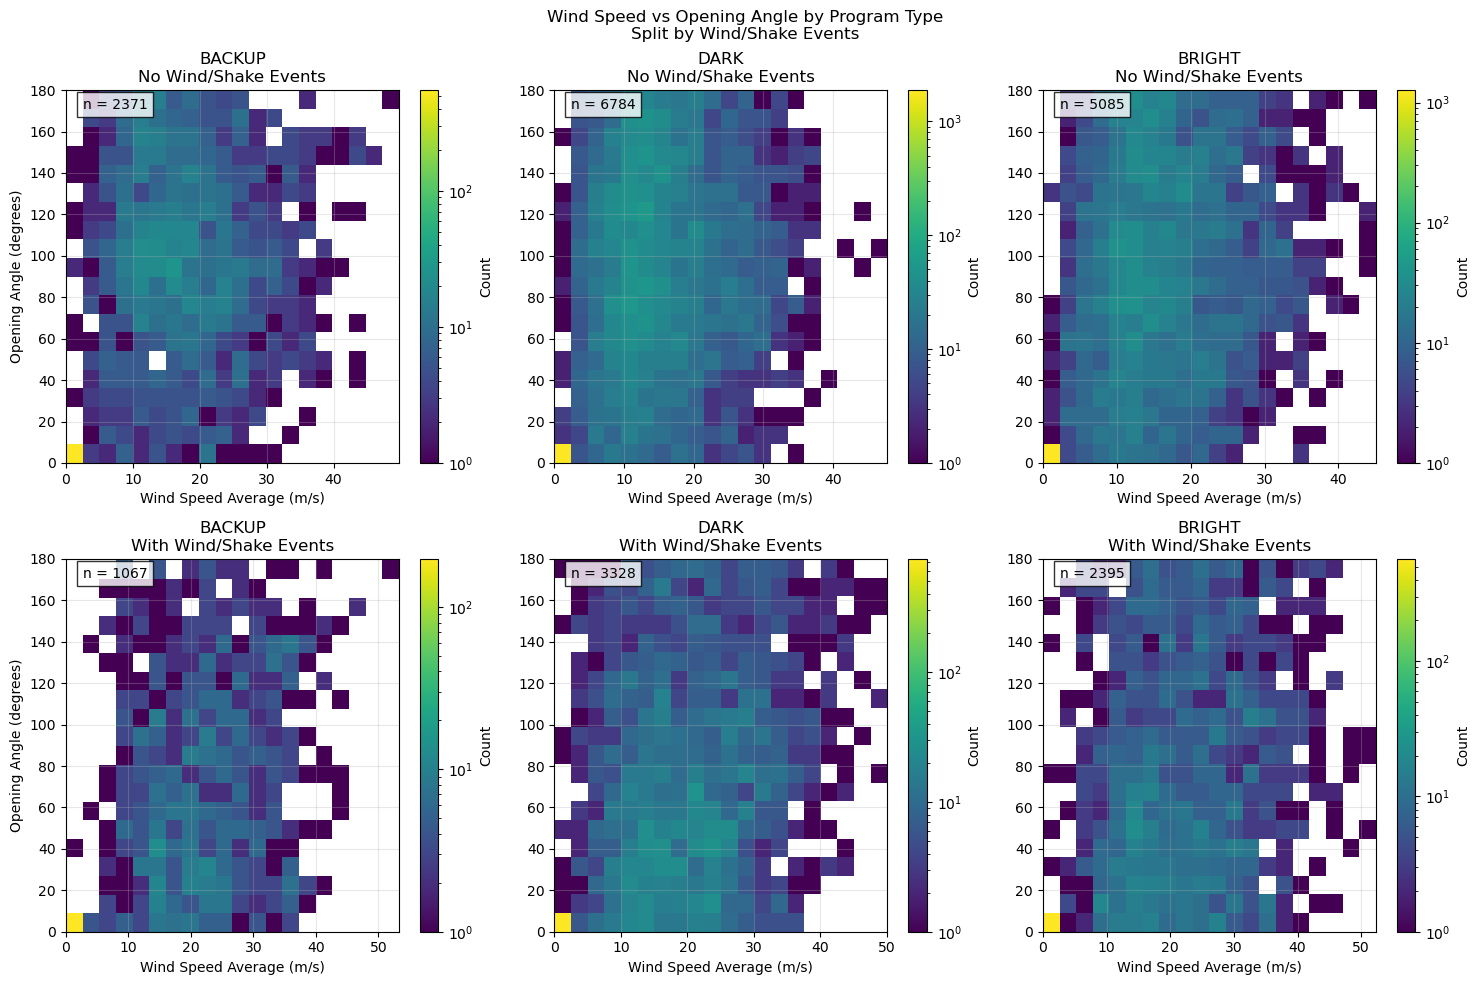

In [39]:
def plot_wind_speed_vs_angle_2dhist(df):
    """
    Create a six-panel 2D histogram of wind speed vs opening angle,
    separated by program type and presence/absence of wind/shake events.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM, WIND_SHAKE_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Wind Speed vs Opening Angle by Program Type\nSplit by Wind/Shake Events')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    
    # Create histogram for each program and condition
    for col, program in enumerate(programs):
        for row, has_events in enumerate([False, True]):
            ax = axes[row, col]
            
            # Create mask for program and wind/shake condition
            program_mask = df['PROGRAM'] == program
            if has_events:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) > 0
                title_prefix = 'With'
            else:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) == 0
                title_prefix = 'No'
            
            combined_mask = program_mask & event_mask
            program_data = df[combined_mask]
            
            # Create 2D histogram
            hist = ax.hist2d(program_data['WIND_SPEED_AVG'], 
                           program_data['WIND_OPENING_ANGLE'],
                           bins=(20, 20),  # You can adjust the number of bins
                           cmap='viridis',
                           norm=plt.matplotlib.colors.LogNorm())  # Use log scale for better visualization
            
            # Add colorbar
            plt.colorbar(hist[3], ax=ax, label='Count')
            
            # Add labels
            ax.set_xlabel('Wind Speed Average (m/s)')
            if col == 0:
                ax.set_ylabel('Opening Angle (degrees)')
            ax.set_title(f'{program}\n{title_prefix} Wind/Shake Events')
            
            # Set y-axis limits
            ax.set_ylim(0, 180)
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add count of points
            count = len(program_data)
            ax.text(0.05, 0.95, f'n = {count}', 
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig, axes

# Create the plot
fig, axes = plot_wind_speed_vs_angle_2dhist(new_exposure_table)
